# TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE


<table>
  <tr><td>
    <img src="https://drive.google.com/uc?id=15eGnAbma5Q_j9CZZKi46Gh3-EpgSWYOV"
         alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1. Classifying disease using Deep Learning 
  </td></tr>
</table>


![alt text](https://drive.google.com/uc?id=19BuQ5m0xZWC7vQN4jX9lukmJ4aE0EkL8)

![alt text](https://drive.google.com/uc?id=10tbeSkGZ0xdHtqTGhYwHhb9PPURw0BfD)

# TASK #2: IMPORT LIBRARIES AND DATASET

In [1]:
# This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.
# Each class contains 133 images.
# Dataset Source:
# https://github.com/ieee8023/covid-chestxray-dataset 
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
# You will need to mount your drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Specify training data directory
X_ray_dir = '/content/drive/My Drive/Colab Notebooks/Data Science/4. Operations Department/Dataset'

In [4]:
# List the folders in the directory
os.listdir(X_ray_dir)

['1', '2', '3', '0']

In [5]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [6]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size=32, directory=X_ray_dir, shuffle=True, target_size=(256,256), class_mode='categorical', subset='training')

Found 428 images belonging to 4 classes.


In [7]:
validation_generator = image_generator.flow_from_directory(batch_size=32, directory=X_ray_dir, shuffle=True, target_size=(256,256), class_mode='categorical', subset='validation')

Found 104 images belonging to 4 classes.


In [8]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [9]:
train_images.shape

(32, 256, 256, 3)

In [10]:
train_labels.shape

(32, 4)

In [11]:
# labels Translator 
label_names = {0: 'Covid-19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

# TASK #3: VISUALIZE DATASET

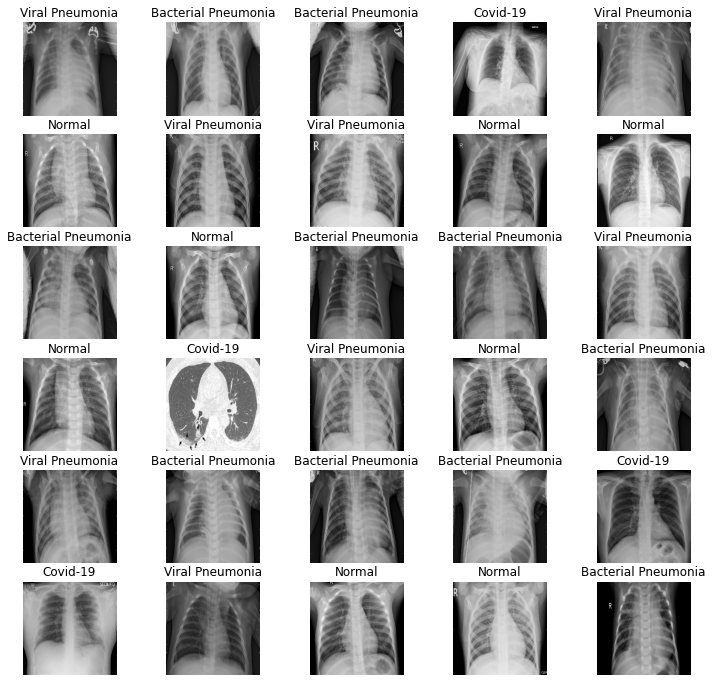

In [12]:
L = 6
W = 5
fig, axes = plt.subplots(L, W, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5) 

# TASK #4: UNDERSTAND THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS

![alt text](https://drive.google.com/uc?id=176TJGdJtNZmX4J5QyeI8W_YS5f1gg5VS)

![alt text](https://drive.google.com/uc?id=1340UvqbXc-sy6cIuVg7ZbOwcga2JxfkP)

![alt text](https://drive.google.com/uc?id=1hngDlUf9JnwUhPII-Ah7KTtcvoeTI9m8)

![alt text](https://drive.google.com/uc?id=1nt8iX7H2LEhaWgGCi_NIb05DMQEoJVfI)

# TASK #5: UNDERSTAND THE THEORY AND INTUITION BEHIND TRANSFER LEARNING

![alt text](https://drive.google.com/uc?id=1Wnti2DSmA2qMRsgkD7Z_MJkmed0bJZTN)

![alt text](https://drive.google.com/uc?id=1Chdq0gdnHGYDDb50pMMtcTOZMr0u37Iz)

![alt text](https://drive.google.com/uc?id=14niGb232X6l8OD1dMT4a_u3fjh_jKuMS)

![alt text](https://drive.google.com/uc?id=1dye4zWALCDu8a1a-58HfZk4On4nVuizV)

# TASK #6: IMPORT MODEL WITH PRETRAINED WEIGHTS

In [13]:
basemodel = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

94781440/94765736 [==============================] - 0s 0us/step


In [14]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [15]:
# freezing layers in the model
for layer in basemodel.layers[:-10]:
  layers.trainable = False

# TASK #7: BUILD AND TRAIN DEEP LEARNING MODEL

In [16]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(512, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(4, activation='softmax')(headmodel)

In [17]:
model = Model(inputs=basemodel.input, outputs=headmodel)

In [35]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [36]:
# using early stopping to exit training if validation loss is not decreasing after certain number of epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=12)
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

In [37]:
train_generator = image_generator.flow_from_directory(batch_size=4, directory=X_ray_dir, shuffle=True, target_size=(256,256), class_mode='categorical', subset='training')
val_generator = image_generator.flow_from_directory(batch_size=4, directory=X_ray_dir, shuffle=True, target_size=(256,256), class_mode='categorical', subset='validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [38]:
history = model.fit_generator(train_generator, epochs=50, validation_data=val_generator, callbacks=[checkpointer, earlystopping])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


107/107 [==============================] - ETA: 0s - loss: 0.1874 - accuracy: 0.9766
Epoch 1: val_loss improved from inf to 1.03122, saving model to weights.hdf5
107/107 [==============================] - 27s 152ms/step - loss: 0.1874 - accuracy: 0.9766 - val_loss: 1.0312 - val_accuracy: 0.9038
Epoch 2/50
107/107 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9907
Epoch 2: val_loss did not improve from 1.03122
107/107 [==============================] - 14s 131ms/step - loss: 0.0387 - accuracy: 0.9907 - val_loss: 2.5782 - val_accuracy: 0.7788
Epoch 3/50
107/107 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 1.03122
107/107 [==============================] - 14s 131ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.3464 - val_accuracy: 0.8654
Epoch 4/50
107/107 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9977
Epoch 4: val_loss did not improve from 1.03122
107/107

# TASK #8: EVALUATE TRAINED DEEP LEARNING MODEL

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0, 0.5, 'Accuracies')

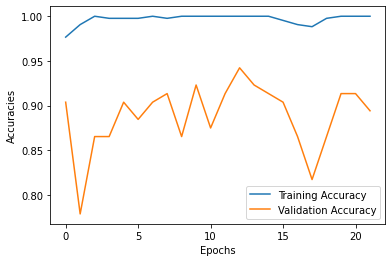

In [40]:
sns.lineplot(y=history.history['accuracy'], x=range(len(history.history['accuracy'])), label='Training Accuracy')
sns.lineplot(y=history.history['val_accuracy'], x=range(len(history.history['accuracy'])), label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')

Text(0, 0.5, 'Losses')

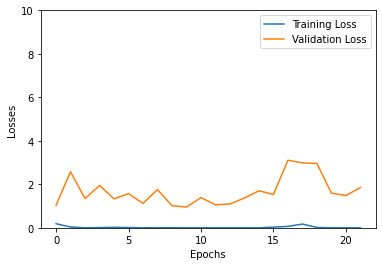

In [42]:
sns.lineplot(y=history.history['loss'], x=range(len(history.history['accuracy'])), label='Training Loss')
sns.lineplot(y=history.history['val_loss'], x=range(len(history.history['accuracy'])), label ='Validation Loss')
plt.ylim(0,10)
plt.xlabel('Epochs')
plt.ylabel('Losses')

In [43]:
test_dir = '/content/drive/My Drive/Colab Notebooks/Data Science/4. Operations Department/Test'

In [44]:
test_gen = ImageDataGenerator(rescale=1./255)

In [45]:
test_generator = test_gen.flow_from_directory(batch_size=40, directory=test_dir, shuffle=True, target_size=(256,256), class_mode='categorical')

Found 40 images belonging to 4 classes.


In [46]:
evaluate = model.evaluate(test_generator, steps=test_generator.n //4, verbose=1)
print('Accuracy Testing: {}'.format(evaluate[1]))

10/10 [==============================] - 2s 5ms/step - loss: 4.7801 - accuracy: 0.7750
Accuracy Testing: 0.7749999761581421


In [47]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_dir))):
  for item in os.listdir(os.path.join(test_dir,str(i))):
    img= cv2.imread(os.path.join(test_dir,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [48]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.775


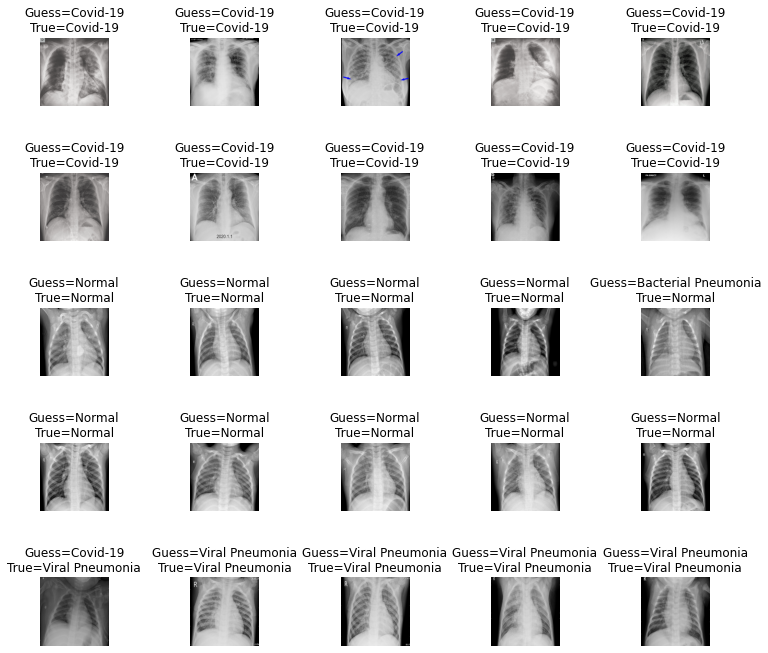

In [49]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [50]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.69      0.90      0.78        10
           2       1.00      0.50      0.67        10
           3       0.70      0.70      0.70        10

    accuracy                           0.78        40
   macro avg       0.81      0.77      0.76        40
weighted avg       0.81      0.78      0.76        40



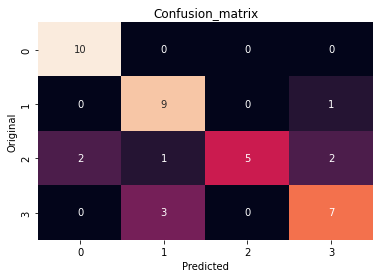

In [51]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cbar=False)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix');

# EXCELLENT JOB! YOU SHOULD BE PROUD OF YOUR NEWLY ACQUIRED SKILLS